## Merging of the data from different sources

In this notebook, we will merge the datas coming from the two different websites. 


In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math

## 1) Merge of the ratings

Different aspects are important for this step: 
- each rating must be present in only one copy (even if it was made on the 2 websites)
- the scores must be comparable between the two sets of data, to allow comparision during the following steps of analysis

From the paper : 

" With this in mind, we designed a matching algorithm geared
toward precision, potentially at the expense of recall."

"This implies that, in order to compare ratings across sites and
time periods, we must account for biases stemming from site conventions (shifted rating histograms) and from a temporal drift in
these conventions (rising means and sinking standard deviations).
Instead of raw ratings, we therefore consider standardized ratings
(also known as z-scores): for each site and each year, we compute
the mean and standard deviation over all ratings. We then subtract
the mean of year t from all ratings submitted in year t and divide
them by the standard deviation of year t, such that each year’s set
of ratings has mean 0 and standard deviation 1."


"Decrivent comment font le matching : d'abord match brewery, puis par bière pour une même brewery --> voir si doit le faire ou si peut utiliser la data déjà présente. --> je pense que les beers et brewery dejà faites conviennent?" We find θ = 0.8
and δ = 0.3"

Instaurent minimum de rating par bière

Matching ensures that each remaining product has been rated
on each of the two websites. As explained in Sec. 2.1 (step 2), each
beer falls into one of nine paired-treatment groups (HH, HM, HL,
MH, etc.). Table 3 displays the size of all groups (for beers with at
least five ratings on each site, as the bulk of our analysis will be
conducted on this set). We observe that the groups are rather well
balanced “out of the box” (e.g., 1,210 beers in HM vs. 1,213 in MH,
etc.), even before balancing them explicitly (step 3 of Sec. 2.1).
We recomputed and inspected the rating histograms (cf. Fig. 3(a))
on the subset of beers in the matched sample only and found them
essentially indistinguishable from the full sample shown in Fig. 3(a).
This implies that the vastly different rating distributions of the two
sites are not caused by users on one of the sites having a systematic
preference for rating inherently better or worse beers (e.g., certain
rating sites might see themselves as “bashing sites”); rather, the
difference must stem from different scoring standards.

--> doit on faire une sorte de matching entre lors du merging ? Si oui, que veut-on matcher?

--> Verifier les rating histogramms, vérifier qu'ils overlap

--> Eux, font le matching avec : nombre de rating per brewery, nombre de rating per beer et valeur des ratings, en comparant les deux sets. 

--> Refaire algo pour merge les data, puis voir comment trier la data, et voir si doit faire matching pour chaque pays par exemple.

**1 —** Loading the data (ratings)

Remark: since the ratings are in text format, they were first converted in csv, with a python script
The data is then put in shape by converting the date format

In [2]:
#Beer Advocate
data_folder = './BeerAdvocate/'
df_ba = pd.read_csv(data_folder + 'ratings.csv')

df_ba.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review
0,Régab,142544,Societe des Brasseries du Gabon (SOBRAGA),37262,Euro Pale Lager,4.5,1440064800,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,"From a bottle, pours a piss yellow color with ...",True
1,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1235127600,StJamesGate,stjamesgate.163714,3.00,3.50,3.50,4.00,3.5,3.67,Pours pale copper with a thin head that quickl...,True
2,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1142247600,mdagnew,mdagnew.19527,4.00,3.50,3.50,4.00,3.5,3.73,"500ml Bottle bought from The Vintage, Antrim.....",True
3,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1101898800,helloloser12345,helloloser12345.10867,4.00,3.50,4.00,4.00,4.5,3.98,Serving: 500ml brown bottlePour: Good head wit...,True
4,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1093860000,cypressbob,cypressbob.3708,4.00,4.00,4.00,4.00,4.0,4.00,"500ml bottlePours with a light, slightly hazy ...",True


In [3]:
#RateBeer

data_folder = './RateBeer/'
df_rb = pd.read_csv(data_folder + 'ratings.csv')
#df_rb=df_ba

In [4]:
#Conversion of the date format

#BeerAdvocate
df_ba.date = pd.to_datetime(df_ba.date, unit='s')


In [5]:
#RateBeer
df_rb.date = pd.to_datetime(df_rb.date, unit='s')

In [6]:
#Checking the two df
df_ba.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review
0,Régab,142544,Societe des Brasseries du Gabon (SOBRAGA),37262,Euro Pale Lager,4.5,2015-08-20 10:00:00,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,"From a bottle, pours a piss yellow color with ...",True
1,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,2009-02-20 11:00:00,StJamesGate,stjamesgate.163714,3.00,3.50,3.50,4.00,3.5,3.67,Pours pale copper with a thin head that quickl...,True
2,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,2006-03-13 11:00:00,mdagnew,mdagnew.19527,4.00,3.50,3.50,4.00,3.5,3.73,"500ml Bottle bought from The Vintage, Antrim.....",True
3,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,2004-12-01 11:00:00,helloloser12345,helloloser12345.10867,4.00,3.50,4.00,4.00,4.5,3.98,Serving: 500ml brown bottlePour: Good head wit...,True
4,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,2004-08-30 10:00:00,cypressbob,cypressbob.3708,4.00,4.00,4.00,4.00,4.0,4.00,"500ml bottlePours with a light, slightly hazy ...",True


In [7]:
df_rb.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
0,33 Export (Gabon),410549,Sobraga,3198,Pale Lager,5.0,2016-04-26 10:00:00,Manslow,175852,2,4,2,4,8,2.0,"Puszka 0,33l dzięki Christoph . Kolor jasnozło..."
1,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2017-02-17 11:00:00,MAGICuenca91,442761,2,3,2,4,8,1.9,Cerveza pale lager gabonesa. MÃ¡s floja que la...
2,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2016-06-24 10:00:00,Sibarh,288889,3,3,2,3,5,1.6,"Kolor- złoty, klarowny. Piana - drobna, średni..."
3,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2016-01-01 11:00:00,fombe89,250510,4,3,1,2,5,1.5,"Botella, de GabÃ³n regalo familiar.31/01/2015C..."
4,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2015-10-23 10:00:00,kevnic2008,122778,2,4,2,4,7,1.9,Many thanks for this beer to Erzengel. Pours l...


**2 -** Normalization of the global ratings

As in the paper, the ratings were normalized by substracting the mean of this year, and dividing by the std of that year. 

/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN 

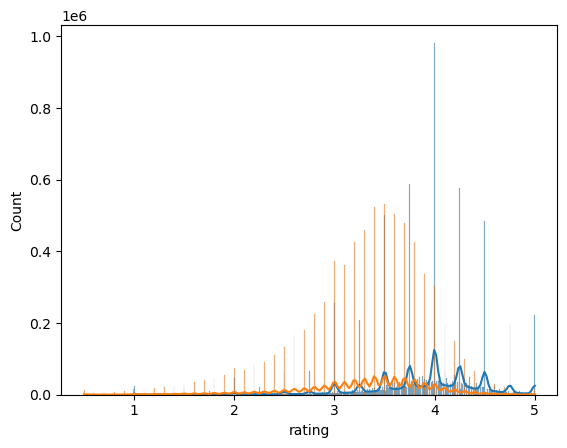

In [8]:
#Plots before normalization

ax = sns.histplot(df_ba['rating'], kde=True, label='BA', log_scale = False)
ax = sns.histplot(df_rb['rating'], kde=True, label='RB', log_scale=False)

In [9]:
#To be able to have the mean by year
#Extract the year from the date and create new column

df_ba['year'] = df_ba['date'].dt.strftime('%Y')
df_rb['year'] = df_rb['date'].dt.strftime('%Y')

In [10]:
df_ba.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review,year
0,Régab,142544,Societe des Brasseries du Gabon (SOBRAGA),37262,Euro Pale Lager,4.5,2015-08-20 10:00:00,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,"From a bottle, pours a piss yellow color with ...",True,2015
1,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,2009-02-20 11:00:00,StJamesGate,stjamesgate.163714,3.00,3.50,3.50,4.00,3.5,3.67,Pours pale copper with a thin head that quickl...,True,2009
2,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,2006-03-13 11:00:00,mdagnew,mdagnew.19527,4.00,3.50,3.50,4.00,3.5,3.73,"500ml Bottle bought from The Vintage, Antrim.....",True,2006
3,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,2004-12-01 11:00:00,helloloser12345,helloloser12345.10867,4.00,3.50,4.00,4.00,4.5,3.98,Serving: 500ml brown bottlePour: Good head wit...,True,2004
4,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,2004-08-30 10:00:00,cypressbob,cypressbob.3708,4.00,4.00,4.00,4.00,4.0,4.00,"500ml bottlePours with a light, slightly hazy ...",True,2004


In [11]:
df_rb.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,year
0,33 Export (Gabon),410549,Sobraga,3198,Pale Lager,5.0,2016-04-26 10:00:00,Manslow,175852,2,4,2,4,8,2.0,"Puszka 0,33l dzięki Christoph . Kolor jasnozło...",2016
1,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2017-02-17 11:00:00,MAGICuenca91,442761,2,3,2,4,8,1.9,Cerveza pale lager gabonesa. MÃ¡s floja que la...,2017
2,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2016-06-24 10:00:00,Sibarh,288889,3,3,2,3,5,1.6,"Kolor- złoty, klarowny. Piana - drobna, średni...",2016
3,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2016-01-01 11:00:00,fombe89,250510,4,3,1,2,5,1.5,"Botella, de GabÃ³n regalo familiar.31/01/2015C...",2016
4,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2015-10-23 10:00:00,kevnic2008,122778,2,4,2,4,7,1.9,Many thanks for this beer to Erzengel. Pours l...,2015


In [12]:
#Normalization
#For each year, substract mean of the year and divide by std

df_ba['normalized'] = (df_ba['rating'] - df_ba.groupby(['year'])['rating'].transform('mean'))/df_ba.groupby(['year'])['rating'].transform('std')
df_rb['normalized'] = (df_rb['rating'] - df_rb.groupby(['year'])['rating'].transform('mean'))/df_rb.groupby(['year'])['rating'].transform('std')


/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN 

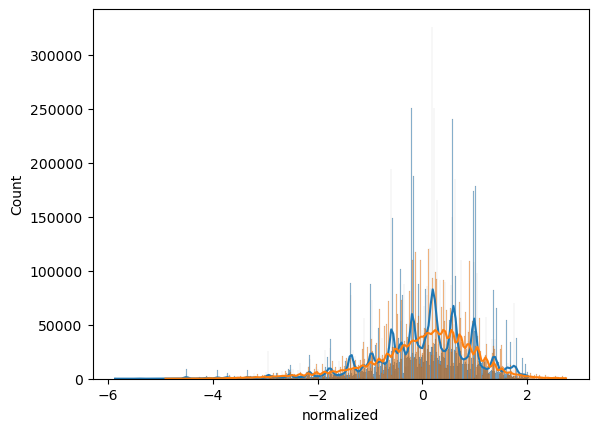

In [13]:
#Observe the distribution of ratings for each website

ax = sns.histplot(df_ba['normalized'], kde=True, label='BA', log_scale = False)
ax = sns.histplot(df_rb['normalized'], kde=True, label='RB', log_scale=False)


**3 -** Dataset combination

Here, we merge the datasets from the 2 websites. Some reviews are present in the two datasets. They are removed from the final dataset. In order to do that, we remove from the dataset the ratings present in the "matched_beer_data" file, that contains the data obtained in both datasets. 

To be able to detect and associate data between the merged df and the two other, we will use different features of the data: the user name, the beer id and the date. To be noted that those informations can differ from the two websites, and that the specific information for each website is used.

In [14]:
#Load the matched data to be able to remove the duplicates

data_folder = './matched_beer_data/'
df_merged = pd.read_csv(data_folder + 'ratings.csv', header=1)

#Convert date format
df_merged.date = pd.to_datetime(df_merged.date, unit='s')
df_merged['date.1'] = pd.to_datetime(df_merged['date.1'], unit='s')
df_merged.head()

,abv,appearance,aroma,beer_id,beer_name,brewery_id,brewery_name,date,overall,palate,...,brewery_name.1,date.1,overall.1,palate.1,rating.1,style.1,taste.1,text.1,user_id.1,user_name.1
0,11.3,4.5,4.5,645,Trappistes Rochefort 10,207,Brasserie de Rochefort,2011-12-25 11:00:00,5.0,4.5,...,Brasserie Rochefort,2013-12-22 11:00:00,19.0,4.0,4.6,Abt/Quadrupel,9.0,a) Geruch malzig-schwer-sÃ¼Ã. Riecht schon ...,83106,Erzengel
1,5.0,NaN,NaN,28191,Myanmar Lager Beer,9369,Myanmar Brewery and Distillery,2011-11-30 11:00:00,NaN,NaN,...,Myanmar Brewery and Distillery,2011-11-29 11:00:00,6.0,2.0,1.7,Pale Lager,4.0,"Can. Weak and watery, not the best beer of the...",91324,visionthing
2,5.0,3.5,3.5,57911,Cantillon Tyrnilambic Baie D’Argousier Lambic,388,Brasserie Cantillon,2012-08-04 10:00:00,4.0,4.0,...,Cantillon,2012-11-22 11:00:00,17.0,4.0,4.1,Lambic Style - Fruit,8.0,"Bottle @ One Pint Pub, Helsinki. Originally ra...",98624,tiong
3,5.0,4.0,3.5,57913,Cantillon Pikkulinnun Viskilambic,388,Brasserie Cantillon,2012-08-04 10:00:00,4.0,4.0,...,Cantillon,2014-11-17 11:00:00,16.0,4.0,4.1,Lambic Style - Unblended,9.0,"Draught @Â Pikkulintu, Helsinki, Finland. A pr...",98624,tiong
4,6.0,4.0,4.0,81125,Drie Fonteinen Oude Geuze - Armand & Tommy,2216,Brouwerij 3 Fonteinen,2012-08-29 10:00:00,4.0,4.0,...,Brouwerij 3 Fonteinen,2012-08-18 10:00:00,16.0,4.0,4.0,Lambic Style - Gueuze,8.0,750ml bottleBottling date: 2011/02/17 - Pours ...,98624,tiong


In [15]:
#List of usernames present in both websites, using BA informations

listed_ba_user=list(df_merged['user_id'])
liste_ba_date = list(df_merged['date'])
listed_ba_beer = list(df_merged['beer_id'])


In [16]:
#List of usernames present in both websites, using RB informations

listed_rb_user=list(df_merged['user_id.1'])
liste_rb_date = list(df_merged['date.1'])
listed_rb_beer = list(df_merged['beer_id.1'])

In [17]:
#Create a tuple, to be able to compare the three corresponding columns to the right combination
couple_ba=list(zip(listed_ba_user, liste_ba_date,listed_ba_beer ))
couple_rb=list(zip(listed_rb_user, liste_rb_date,listed_rb_beer ))

In [18]:
#Select only the rows that don't match the pairs for BA
df_ba_removed = df_ba[~df_ba.set_index(['user_id','date', 'beer_id']).index.isin(couple_ba)]

In [19]:
#Select only the rows that don't match the pairs for RB
df_rb_removed = df_rb[~df_rb.set_index(['user_id','date', 'beer_id']).index.isin(couple_rb)]

In [20]:
#Verification of the shapes: 
print(f"Length of orginal ba : {df_ba['user_id'].count()}")
print(f"Length of ba with removed deplicates: {df_ba_removed['user_id'].count()}")
print(f"Difference in length: { df_ba['user_id'].count() - df_ba_removed['user_id'].count()}")
print(f"Length of merged data: {df_merged['user_id'].count()} ")

Length of orginal ba : 8393032
Length of ba with removed deplicates: 8371068
Difference in length: 21964
Length of merged data: 21964 


In [21]:
#Verification of the shapes: 
print(f"Length of orginal rb : {df_rb['user_id'].count()}")
print(f"Length of rb with removed deplicates: {df_rb_removed['user_id'].count()}")
print(f"Difference in length: { df_rb['user_id'].count() - df_rb_removed['user_id'].count()}")
print(f"Length of merged data: {df_merged['user_id'].count()} ")

Length of orginal rb : 7122074
Length of rb with removed deplicates: 7100110
Difference in length: 21964
Length of merged data: 21964 


**4 -** Merging  the obtained datasets

In [22]:
#Merge the two datasets 
df_tot_no_dup = pd.concat([df_ba_removed, df_rb_removed], ignore_index=True)

In [23]:
#Verify the length

print(f"Length of ba with removed duplicates : {df_ba_removed['user_id'].count()}")
print(f"Length of rb with removed deplicates: {df_rb_removed['user_id'].count()}")
print(f"Sum in length: { df_ba_removed['user_id'].count() + df_rb_removed['user_id'].count()}")
print(f"Length of final dataset: {df_tot_no_dup ['user_id'].count()} ")


Length of ba with removed duplicates : 8371068
Length of rb with removed deplicates: 7100110
Sum in length: 15471178
Length of final dataset: 15471178 


**5 -** Adding the data present in the two websites

We add the score by adding the mean z-score between the two websites. 
Determine if we want that or not

Before merging all datasets, must have same columns: for now just drop duplicate columns in merged
Actually, for me doesn't make so much sense to add the duplicates back, since some parameters change between both? Except if we consider only the total rating. Should do zscore for each 'subrating'?


In [24]:
#Compute z-score for the merged dataset, for ba and rb
df_merged['year'] = df_merged['date'].dt.strftime('%Y')
df_merged['year.1'] = df_merged['date.1'].dt.strftime('%Y')
df_merged['normalized_ba'] = (df_merged['rating'] - df_merged.groupby(['year'])['rating'].transform('mean'))/df_merged.groupby(['year'])['rating'].transform('std')
df_merged['normalized.1'] = (df_merged['rating.1'] - df_merged.groupby(['year'])['rating'].transform('mean'))/df_merged.groupby(['year'])['rating'].transform('std')



In [25]:
#Remark: sometimes not the same year between rb and ba, and still associated in the merged df : do we want to change that?
#Other remark: how to merge since different values sometimes?
#Need to remove no-sense columns during merging (for ex beer-id)?


In [26]:
df_merged['normalized'] = df_merged[['normalized_ba','normalized.1']].mean(axis=1)

In [36]:
#TODO: merging (after discussion)

## 2) Merge breweries

Verify that the breweries are the same for each dataset. 
If the number of beers from one brewery is not consistent, what to do ? Is it important for our anlaysis? 

QUESTION: does the number of beer per brewery matter to us ? If yes, need to do some stuff: like see if the beers are the same between the two websites, and only count once the beers for the number of beer per brewery.

In [28]:
#Open datasets for breweries

#Beer Advocate
data_folder = './BeerAdvocate/'
df_ba_breweries = pd.read_csv(data_folder + 'breweries.csv')

In [29]:
df_ba_breweries

,id,location,name,nbr_beers
0,39912,Kyrgyzstan,Abdysh-Ata (Абдыш Ата),5
1,39913,Kyrgyzstan,Arpa (АРПА),1
2,39914,Kyrgyzstan,Bear Beer,4
3,39915,Kyrgyzstan,Blonder Pub,4
4,39916,Kyrgyzstan,Kellers Bier,2
...,...,...,...,...
16753,128,Germany,Privatbrauerei Franz Joseph Sailer,6
16754,5023,Aruba,Aruba Brewing,0
16755,1573,"United States, New York",John Harvard’s Brewery & Ale House,491
16756,16186,"United States, North Carolina",Triangle Brewing Company,20


In [33]:
#RateBeer
data_folder = './RateBeer/'
df_rb_breweries = pd.read_csv(data_folder + 'breweries.csv')

In [31]:
#matched
data_folder = './matched_beer_data/'
df_matched_breweries = pd.read_csv(data_folder + 'breweries.csv')

In [32]:
df_matched_breweries

,ba,ba.1,ba.2,ba.3,rb,rb.1,rb.2,rb.3,scores,scores.1
0,id,location,name,nbr_beers,id,location,name,nbr_beers,diff,sim
1,10093,Northern Ireland,Strangford Lough Brewing Company Ltd,5,4959,Northern Ireland,Strangford Lough,5,0.43127548708778424,0.8890620997705575
2,32848,Northern Ireland,The Sheelin Brewery,4,17616,Northern Ireland,Sheelin,2,0.52638836243535,0.8635957345058749
3,40360,Northern Ireland,Walled City Brewing Company,6,24866,Northern Ireland,Walled City,3,0.5278523214614645,0.9541834284914152
4,40309,Northern Ireland,Ards Brewing Company,7,13538,Northern Ireland,Ards Brewing Co.,13,0.5543953017091594,0.8960983801420876
...,...,...,...,...,...,...,...,...,...,...
8277,10673,"United States, Indiana",Warbird Brewing Company,6,5358,"United States, Indiana",Warbird Brewing Company,6,0.658296921567072,1.0000000000000002
8278,34365,France,Brasserie De La Goutte D'Or,0,16083,France,Goutte dOr,24,0.41273121202344343,0.8489343130202691
8279,23693,South Africa,Luyt Brewery,0,13836,South Africa,Luyt Brewery,1,0.7063389421384024,1.0000000000000002
8280,5025,Aruba,Cerbeseria Arubano,0,2409,Aruba,Cerbeseria Arubano,1,1.0000000000000002,1.0000000000000002


In [ ]:
#Combine breweries that are the same for two datasets, for now remove the duplicates?
#TODO: see if could only keep beers that are not similar, and have a count considering that
#Warning: maybe not exactly same name(sometimes have the name of the brewery, sometimes not) --> if needed, see that

## 3) Merge users

To be able to know how many users in each country, and how many review per user. 
 - Merge the users
 - Combine when users are the same --> same principle as with ratings: remove duplicates for now
 - Take their total number of reviews (in both websites)--> or remove if duplicate review?? --> For now, remove reviews that were removed in rating? Or just to addition ? Since maybe it is relevant if the user is twice as active?

In [34]:
#Beer Advocate
data_folder = './BeerAdvocate/'
df_ba_users = pd.read_csv(data_folder + 'users.csv')

In [35]:
df_ba_users

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location
0,7820,465,nmann08.184925,nmann08,1.199704e+09,"United States, Washington"
1,2521,2504,stjamesgate.163714,StJamesGate,1.191838e+09,"United States, New York"
2,1797,1143,mdagnew.19527,mdagnew,1.116410e+09,Northern Ireland
3,31,31,helloloser12345.10867,helloloser12345,1.101380e+09,Northern Ireland
4,604,604,cypressbob.3708,cypressbob,1.069326e+09,Northern Ireland
...,...,...,...,...,...,...
153699,1,1,everman.532342,Everman,1.291115e+09,"United States, California"
153700,1,1,justin0001.352175,Justin0001,1.248343e+09,"United States, California"
153701,1,0,kyungsup.982216,Kyungsup,1.430561e+09,NaN
153702,1,1,joetex.800347,JoeTex,1.400234e+09,"United States, California"


In [37]:
#RateBeer
data_folder = './RateBeer/'
df_rb_users = pd.read_csv(data_folder + 'users.csv')

In [40]:
#Merged

#Beer Advocate
data_folder = './matched_beer_data/'
df_matched_users = pd.read_csv(data_folder + 'users.csv', header=1)

In [41]:
df_matched_users

,joined,location,nbr_ratings,nbr_reviews,user_id,user_name,user_name_lower,joined.1,location.1,nbr_ratings.1,user_id.1,user_name.1,user_name_lower.1
0,1.220868e+09,Germany,6,6,erzengel.248045,Erzengel,erzengel,1.224324e+09,Germany,8781,83106,Erzengel,erzengel
1,1.348394e+09,"United States, Virginia",1,1,gendv138.695700,GenDV138,gendv138,1.385723e+09,"United States, Virginia",6240,290599,GenDV138,gendv138
2,1.207303e+09,"United States, Washington",3,3,nimbleprop.208928,nimbleprop,nimbleprop,1.150798e+09,"United States, Washington",7452,38859,nimbleprop,nimbleprop
3,1.322737e+09,Estonia,11,0,visionthing.639993,visionthing,visionthing,1.242986e+09,Estonia,5462,91324,visionthing,visionthing
4,1.432116e+09,England,1,0,lazypyro.989356,LazyPyro,lazypyro,1.431166e+09,England,1096,368991,LazyPyro,lazypyro
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3015,1.253182e+09,"United States, Pennsylvania",398,398,shadesofgray.371155,ShadesOfGray,shadesofgray,1.261998e+09,"United States, Pennsylvania",1,99346,ShadesOfGray,shadesofgray
3016,1.095847e+09,"United States, Michigan",587,587,ypsifly.8833,ypsifly,ypsifly,1.139569e+09,"United States, Michigan",1,33393,ypsifly,ypsifly
3017,1.047121e+09,"United States, Texas",1379,1379,hardtarget.1712,HardTarget,hardtarget,1.095934e+09,"United States, Texas",1,15553,HardTarget,hardtarget
3018,1.416740e+09,Vietnam,176,24,nelsonsaigon.897449,nelsonsaigon,nelsonsaigon,1.406369e+09,Vietnam,1,327965,nelsonsaigon,nelsonsaigon


In [ ]:
#For now, remove ratings? Or it doesn't make sense to remove them just because they rate two times?
#Would say, for the number of rating, the overall activity is relevant
#See how to know if a rating is for the same beer at the same time? 

#For  now: remove users that are in the two datasets from each website
#Add the merged dataset, while adding between them the number of rating for each website



In [42]:
#Remove from BeerAdvocate the users that are in the two websites: 

listed_ba_users=list(df_matched_users['user_id'])

#Select only the rows that don't match the pairs for BA
df_ba_user_removed = df_ba_users[~df_ba_users.set_index(['user_id']).index.isin(listed_ba_users)]


In [43]:
df_ba_user_removed

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location
1,2521,2504,stjamesgate.163714,StJamesGate,1.191838e+09,"United States, New York"
2,1797,1143,mdagnew.19527,mdagnew,1.116410e+09,Northern Ireland
3,31,31,helloloser12345.10867,helloloser12345,1.101380e+09,Northern Ireland
4,604,604,cypressbob.3708,cypressbob,1.069326e+09,Northern Ireland
5,2326,0,hellpop65.48993,Hellpop65,1.131966e+09,"United States, Kansas"
...,...,...,...,...,...,...
153699,1,1,everman.532342,Everman,1.291115e+09,"United States, California"
153700,1,1,justin0001.352175,Justin0001,1.248343e+09,"United States, California"
153701,1,0,kyungsup.982216,Kyungsup,1.430561e+09,NaN
153702,1,1,joetex.800347,JoeTex,1.400234e+09,"United States, California"


In [44]:
#Remove from RateBeer the users that are in the two websites: 

listed_rb_users=list(df_matched_users['user_id.1'])

#Select only the rows that don't match the pairs for BA
df_rb_user_removed = df_rb_users[~df_rb_users.set_index(['user_id']).index.isin(listed_rb_users)]

In [46]:
df_rb_users

,nbr_ratings,user_id,user_name,joined,location
0,1890,175852,Manslow,1.337508e+09,Poland
1,89,442761,MAGICuenca91,1.484046e+09,Spain
2,169,288889,Sibarh,1.384600e+09,Poland
3,3371,250510,fombe89,1.363950e+09,Spain
4,13043,122778,kevnic2008,1.296644e+09,Germany
...,...,...,...,...,...
70169,1,134893,stamfordbus,1.315217e+09,England
70170,1,327816,fobia405,1.406282e+09,Belgium
70171,1,183139,junkin,1.339841e+09,NaN
70172,3,82020,klesidra,1.222250e+09,Slovenia


In [45]:
df_rb_user_removed

,nbr_ratings,user_id,user_name,joined,location
0,1890,175852,Manslow,1.337508e+09,Poland
1,89,442761,MAGICuenca91,1.484046e+09,Spain
2,169,288889,Sibarh,1.384600e+09,Poland
3,3371,250510,fombe89,1.363950e+09,Spain
4,13043,122778,kevnic2008,1.296644e+09,Germany
...,...,...,...,...,...
70169,1,134893,stamfordbus,1.315217e+09,England
70170,1,327816,fobia405,1.406282e+09,Belgium
70171,1,183139,junkin,1.339841e+09,NaN
70172,3,82020,klesidra,1.222250e+09,Slovenia


In [54]:
df_matched_users['joined'] = pd.to_datetime(df_matched_users.joined, unit='s')

In [55]:
df_matched_users['joined.1'] = pd.to_datetime(df_matched_users['joined.1'], unit='s')

In [57]:
df_matched_users['joined_tot'] = df_matched_users[['joined.1','joined']].mean(axis=1)

In [49]:
#Get the total number of reviews for each user

df_matched_users['ratings_tot']=df_matched_users['nbr_ratings'] +df_matched_users['nbr_ratings.1']
 #No data for the number of reviews in rb

In [58]:
df_matched_users
#joined = date? which one to choose? See that
#Tke the first date?
#Problem with the dates, see how to do!


,joined,location,nbr_ratings,nbr_reviews,user_id,user_name,user_name_lower,joined.1,location.1,nbr_ratings.1,user_id.1,user_name.1,user_name_lower.1,ratings_tot,date,joined_tot
0,2008-09-08 10:00:00,Germany,6,6,erzengel.248045,Erzengel,erzengel,2008-10-18 10:00:00,Germany,8781,83106,Erzengel,erzengel,8787,2008-09-08 10:00:00,2008-09-28 10:00:00
1,2012-09-23 10:00:00,"United States, Virginia",1,1,gendv138.695700,GenDV138,gendv138,2013-11-29 11:00:00,"United States, Virginia",6240,290599,GenDV138,gendv138,6241,2012-09-23 10:00:00,2013-04-27 10:30:00
2,2008-04-04 10:00:00,"United States, Washington",3,3,nimbleprop.208928,nimbleprop,nimbleprop,2006-06-20 10:00:00,"United States, Washington",7452,38859,nimbleprop,nimbleprop,7455,2008-04-04 10:00:00,2007-05-13 10:00:00
3,2011-12-01 11:00:00,Estonia,11,0,visionthing.639993,visionthing,visionthing,2009-05-22 10:00:00,Estonia,5462,91324,visionthing,visionthing,5473,2011-12-01 11:00:00,2010-08-26 22:30:00
4,2015-05-20 10:00:00,England,1,0,lazypyro.989356,LazyPyro,lazypyro,2015-05-09 10:00:00,England,1096,368991,LazyPyro,lazypyro,1097,2015-05-20 10:00:00,2015-05-14 22:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3015,2009-09-17 10:00:00,"United States, Pennsylvania",398,398,shadesofgray.371155,ShadesOfGray,shadesofgray,2009-12-28 11:00:00,"United States, Pennsylvania",1,99346,ShadesOfGray,shadesofgray,399,2009-09-17 10:00:00,2009-11-07 10:30:00
3016,2004-09-22 10:00:00,"United States, Michigan",587,587,ypsifly.8833,ypsifly,ypsifly,2006-02-10 11:00:00,"United States, Michigan",1,33393,ypsifly,ypsifly,588,2004-09-22 10:00:00,2005-06-02 10:30:00
3017,2003-03-08 11:00:00,"United States, Texas",1379,1379,hardtarget.1712,HardTarget,hardtarget,2004-09-23 10:00:00,"United States, Texas",1,15553,HardTarget,hardtarget,1380,2003-03-08 11:00:00,2003-12-15 22:30:00
3018,2014-11-23 11:00:00,Vietnam,176,24,nelsonsaigon.897449,nelsonsaigon,nelsonsaigon,2014-07-26 10:00:00,Vietnam,1,327965,nelsonsaigon,nelsonsaigon,177,2014-11-23 11:00:00,2014-09-24 10:30:00


In [59]:
#Get df with right columns

df_matched_tomerge = df_matched_users[['nbr_ratings', 'user_id', 'user_name', 'joined_tot', 'location']]

In [64]:
df_matched_tomerge['joined'] = df_matched_tomerge['joined_tot']
df_matched_tomerge = df_matched_tomerge.drop(columns='joined_tot')

/var/folders/j6/rzgm__cn4mz7qr7w0g71wb9w0000gn/T/ipykernel_23288/1133409138.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_matched_tomerge['joined'] = df_matched_tomerge['joined_tot']


In [65]:
df_matched_tomerge

,nbr_ratings,user_id,user_name,location,joined
0,6,erzengel.248045,Erzengel,Germany,2008-09-28 10:00:00
1,1,gendv138.695700,GenDV138,"United States, Virginia",2013-04-27 10:30:00
2,3,nimbleprop.208928,nimbleprop,"United States, Washington",2007-05-13 10:00:00
3,11,visionthing.639993,visionthing,Estonia,2010-08-26 22:30:00
4,1,lazypyro.989356,LazyPyro,England,2015-05-14 22:00:00
...,...,...,...,...,...
3015,398,shadesofgray.371155,ShadesOfGray,"United States, Pennsylvania",2009-11-07 10:30:00
3016,587,ypsifly.8833,ypsifly,"United States, Michigan",2005-06-02 10:30:00
3017,1379,hardtarget.1712,HardTarget,"United States, Texas",2003-12-15 22:30:00
3018,176,nelsonsaigon.897449,nelsonsaigon,Vietnam,2014-09-24 10:30:00


In [63]:
df_ba_user_removed = df_ba_user_removed.drop(columns='nbr_reviews')

In [66]:
df_users_tot = pd.concat([df_ba_user_removed, df_rb_user_removed, df_matched_tomerge], ignore_index=True)

In [68]:
#Verify the sizes

## 4) Merge beers

Add each beer, its mean rating (with the computed score), location, and number of review. 

Remove duplicate reviews too for this one? They already did some kind of scores. 

See if we want to only keep ratings that are "full" ---> Or different for each part of the project? Depending on if we want to study which aspect is the most valueed for each beer vs which beer is most rated/best rated overall. --> TO DISCUSS


In [ ]:
#Ideas: 

#Rating distribution
